# Positional Encoding

Transformers, unlike RNNs, do not process tokens sequentially. 
They operate on the entire sequence simultaneously, so they lack inherent information 
about the order of tokens. Positional encoding injects this information into the input embeddings.


## Absolute Positional Encoding

The original transformer model introduces a sinusoidal positional encoding:

* Alternates between sine and cosine functions for even and odd dimensions.
* Encodes each position as a vector:

$$
   PE_{\text{pos}, 2i} = \sin\left(\frac{\text{pos}}{10000^{\frac{2i}{d}}}\right), \quad
   PE_{\text{pos}, 2i+1} = \cos\left(\frac{\text{pos}}{10000^{\frac{2i}{d}}}\right)
$$ 
   
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Where $pos$ is the position and $i$ is the dimension index.


In [11]:
import jax.numpy as jnp
from flax import nnx
import pytest
import matplotlib.pyplot as plt
import seaborn as sns


In [6]:
def compute_positional_encoding(d_model: int, max_seq_len: int = 512) -> jnp.ndarray:
    """
    Computes the positional encoding for a given sequence length and embedding dimension.
    
    Args:
        d_model (int): The dimension of the model (embedding size).
        max_seq_len (int): The maximum sequence length for which positional encodings
                           are computed.
    
    Returns:
        jnp.ndarray: The computed positional encodings of shape (1, max_seq_len, d_model).
    """
    # Initialize positional encoding array
    pe = jnp.zeros((max_seq_len, d_model))
    
    # Create position indices for the sequence
    position = jnp.arange(0, max_seq_len, dtype=jnp.float32)[:, jnp.newaxis]
    
    # Calculate the division term for the sine and cosine functions
    div_term = jnp.exp(jnp.arange(0, d_model, 2) * (jnp.log(10000.0) / d_model))  # exp(log(x)) = x
    
    # Apply the sine and cosine functions to even and odd indices
    pe = pe.at[:, 0::2].set(jnp.sin(position / div_term))
    pe = pe.at[:, 1::2].set(jnp.cos(position / div_term))
    
    # Expand the positional encoding to have a batch dimension
    pe = jnp.expand_dims(pe, axis=0)
    
    return pe


First few values of the positional encoding: (Array(0., dtype=float32), Array(0.84147096, dtype=float32), Array(0.9092974, dtype=float32))


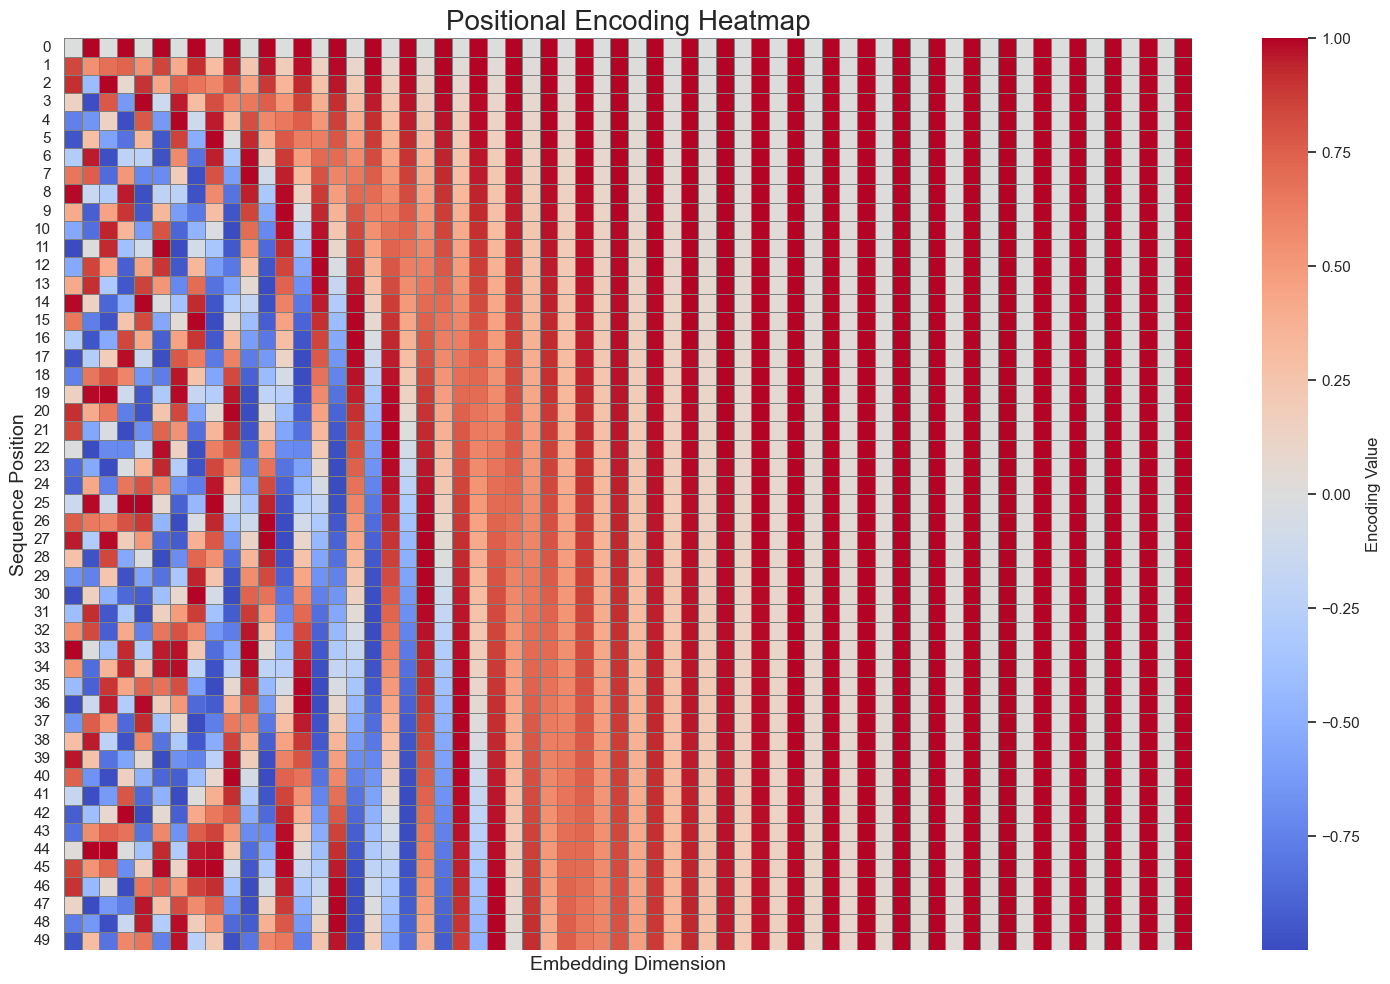

In [17]:
# 1. Testing the function
def test_positional_encoding():
    # Test case 1: Check the shape of the returned positional encoding
    d_model = 64
    max_seq_len = 100
    pe = compute_positional_encoding(d_model, max_seq_len)
    assert pe.shape == (1, max_seq_len, d_model), f"Expected shape (1, {max_seq_len}, {d_model}), but got {pe.shape}"

    # Test case 2: Check the first few values of the positional encoding
    expected_values = pe[0, 0, 0], pe[0, 1, 0], pe[0, 2, 0]
    print(f"First few values of the positional encoding: {expected_values}")

test_positional_encoding()

# 2. Plotting the Positional Encodings
def plot_positional_encoding(pe: jnp.ndarray, max_seq_len: int, d_model: int):
    # Convert JAX array to numpy array for plotting
    pe = jnp.array(pe)

    # Set the seaborn style for the plot
    sns.set(style="whitegrid", palette="muted")

    plt.figure(figsize=(15, 10))
    
    # Use seaborn's heatmap for a better-looking plot
    ax = sns.heatmap(pe[0], cmap='coolwarm', cbar_kws={'label': 'Encoding Value'}, 
                     xticklabels=False, yticklabels=True, square=False, linewidths=0.5, linecolor='gray')
    
    # Set plot title and labels
    ax.set_title('Positional Encoding Heatmap', fontsize=20)
    ax.set_xlabel('Embedding Dimension', fontsize=14)
    ax.set_ylabel('Sequence Position', fontsize=14)
    
    # Rotate y-axis labels and improve layout
    plt.xticks(rotation=90)
    plt.tight_layout()
    
    plt.show()

# Compute positional encoding and plot it
d_model = 64
max_seq_len = 50
pe = compute_positional_encoding(d_model, max_seq_len)
plot_positional_encoding(pe, max_seq_len, d_model)

## Relative Positional Encoding
Relative positional encoding replaces absolute positions with the distance between tokens:

* More expressive for certain tasks (e.g., dependency parsing).
* Commonly used in models like T5, ALiBi, and DeBERTa.

In [14]:
def compute_relative_positional_encoding(max_seq_len: int) -> jnp.ndarray:
    """
    Computes the relative positional encoding for a sequence of given length.

    Args:
        max_seq_len (int): The maximum sequence length.

    Returns:
        jnp.ndarray: A 2D array of shape (max_seq_len, max_seq_len) representing
                     the relative positional encoding.
    """
    # Create the positional indices
    pe = jnp.arange(max_seq_len)
    
    # Compute the relative positional encoding (RPE)
    rpe = pe - pe[:, jnp.newaxis]  # Shape: (max_seq_len, max_seq_len)
    
    # Offset the RPE to ensure non-negative values
    rpe += max_seq_len
    
    return rpe


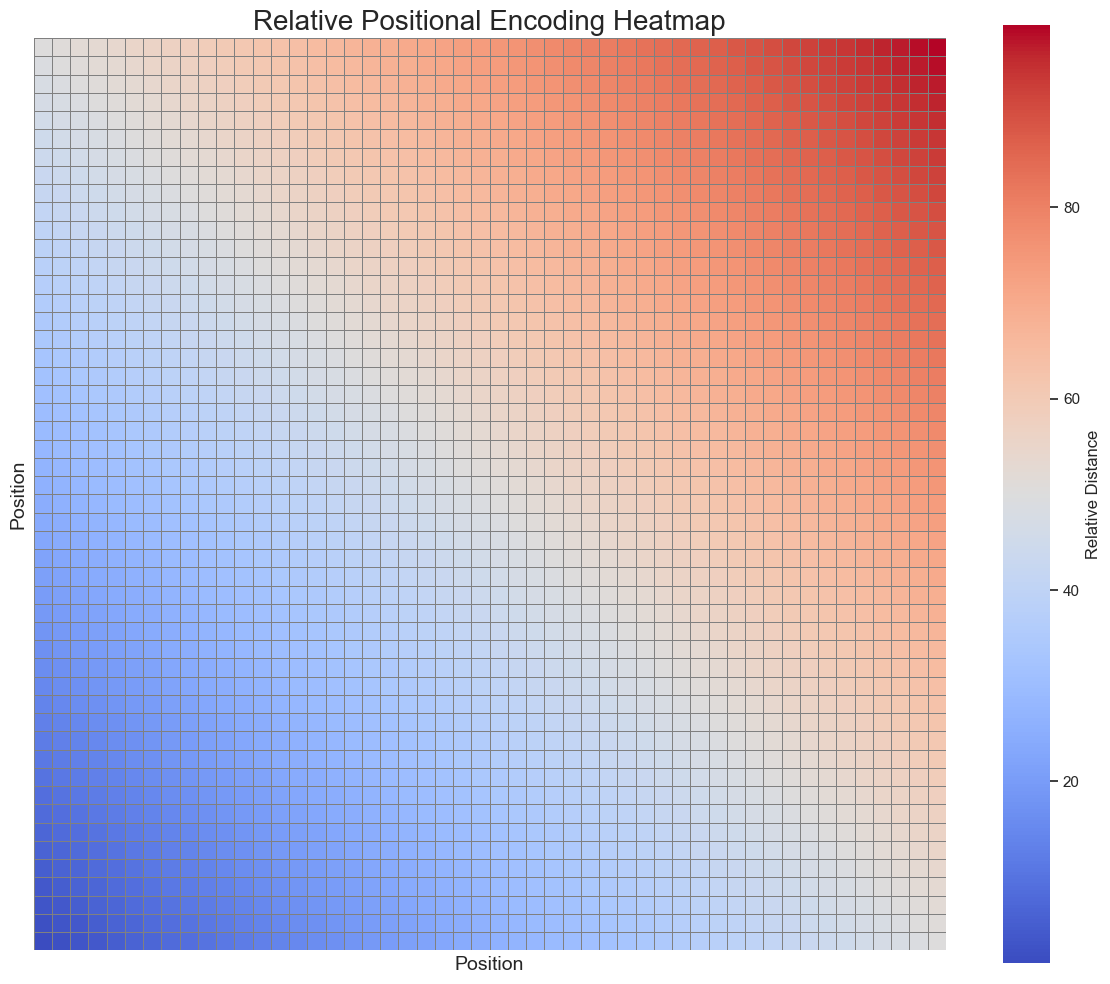

In [18]:
# Improved plotting function for relative positional encoding
def plot_relative_positional_encoding(rpe: jnp.ndarray, max_seq_len: int):
    rpe = jnp.array(rpe)

    # Set the seaborn style for the plot
    sns.set_theme(style="whitegrid", palette="muted")

    plt.figure(figsize=(12, 10))
    
    # Use seaborn's heatmap for a better-looking plot
    ax = sns.heatmap(rpe, cmap='coolwarm', cbar_kws={'label': 'Relative Distance'}, 
                     xticklabels=False, yticklabels=False, square=True, linewidths=0.5, linecolor='gray')
    
    # Set plot title and labels
    ax.set_title('Relative Positional Encoding Heatmap', fontsize=20)
    ax.set_xlabel('Position', fontsize=14)
    ax.set_ylabel('Position', fontsize=14)
    
    # Improve layout
    plt.xticks(rotation=90)
    plt.tight_layout()
    
    plt.show()

# Compute relative positional encoding and plot it
max_seq_len = 50
rpe = compute_relative_positional_encoding(max_seq_len)
plot_relative_positional_encoding(rpe, max_seq_len)